CARGANDO DATASET DE DIVORCIOS
Shape divorcios: (56349, 12)
Columnas: ['AÑOREG', 'DEPOCU', 'DEPREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ', 'MESOCU', 'MESREG', 'MUPOCU', 'MUPREG', 'NACHOM', 'NACMUJ']

CARGANDO DATASET DE MATRIMONIOS
Shape matrimonios: (752264, 15)
Columnas: ['AÑOREG', 'CLAUNI', 'DEPOCU', 'DEPREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ', 'ESCHOM', 'ESCMUJ', 'MESOCU', 'MESREG', 'MUPOCU', 'MUPREG', 'NACHOM', 'NACMUJ']
Convirtiendo columnas numéricas - DIVORCIOS
  AÑOREG: 56349/56349 válidos (100.0%)
  DIAOCU: 56349/56349 válidos (100.0%)
  EDADHOM: 25467/56349 válidos (45.2%)
  EDADMUJ: 25584/56349 válidos (45.4%)

Convirtiendo columnas numéricas - MATRIMONIOS
  AÑOREG: 752264/752264 válidos (100.0%)
  DIAOCU: 752264/752264 válidos (100.0%)
  EDADHOM: 751969/752264 válidos (100.0%)
  EDADMUJ: 751931/752264 válidos (100.0%)
LIMPIEZA DE DEPARTAMENTOS - DIVORCIOS
Valores únicos antes:
<StringArray>
['Quetzaltenango',      'Guatemala',         'Izabal',         'Jalapa',
   'Sacatepequez',  

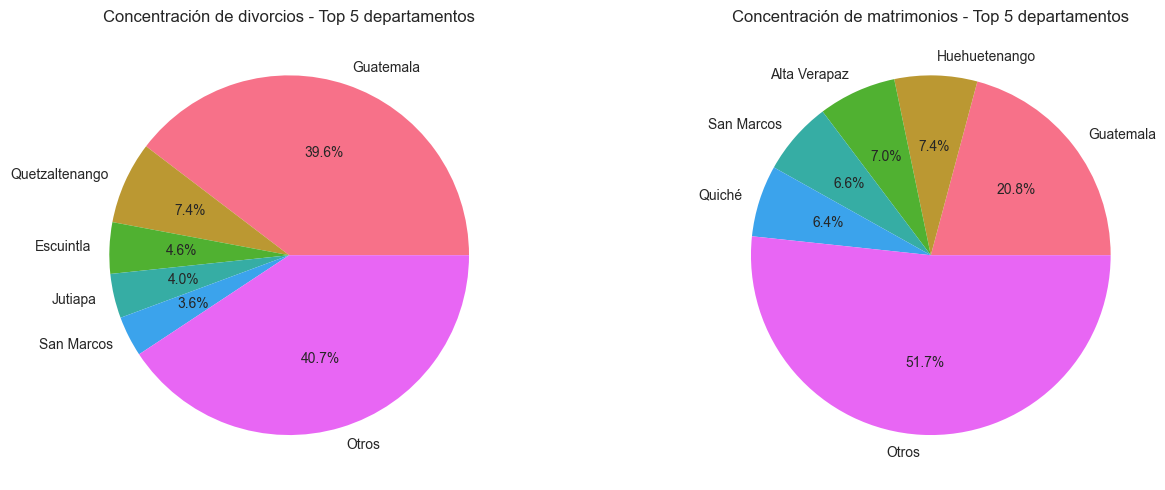

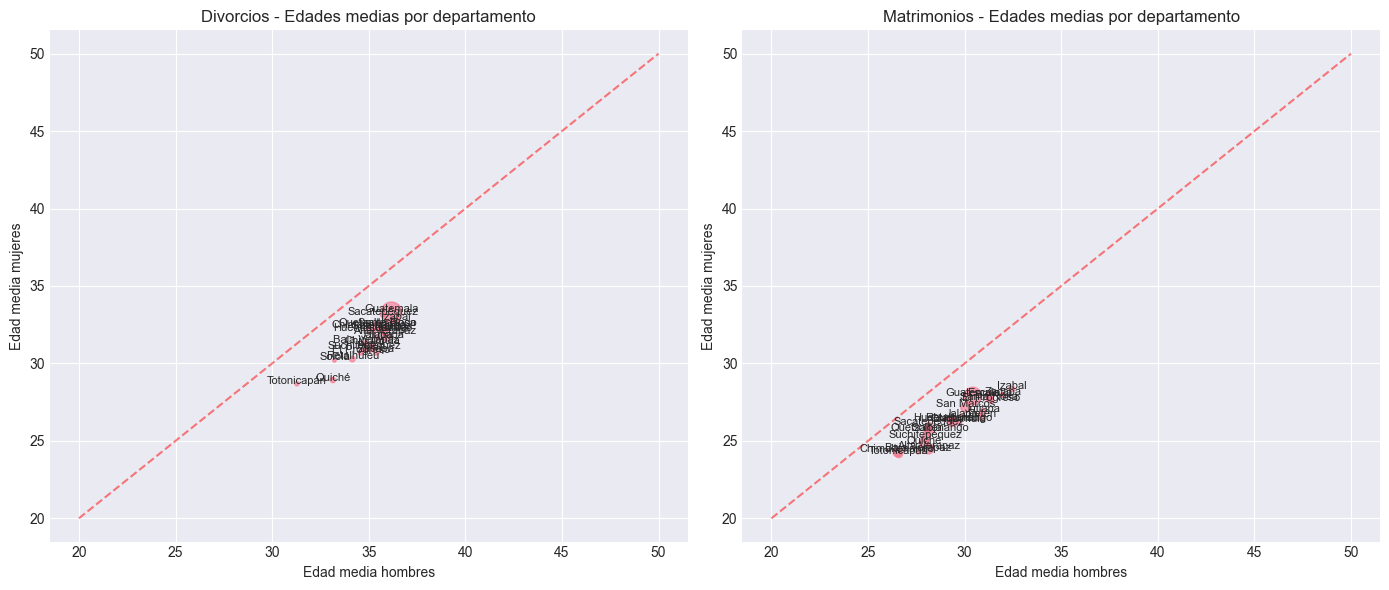

In [2]:
# %% [markdown]
# # Análisis de Clustering - Divorcios y Matrimonios en Guatemala
# 
# **Objetivos:**
# 1. Analizar la estabilidad matrimonial (relación divorcios/matrimonios por departamento)
# 2. Analizar la concentración urbana de divorcios vs matrimonios
# 3. Analizar la duración promedio del matrimonio (usando edades como proxy)
# 
# **Estructura:**
# - Carga y limpieza de ambos datasets
# - Agregación por departamento
# - Preparación para clustering

# %% [markdown]
# ## 1. Importar librerías

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')




# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# %% [markdown]
# ## 2. Cargar datasets

# %%
# Cargar datos de divorcios
print("=" * 60)
print("CARGANDO DATASET DE DIVORCIOS")
print("=" * 60)
df_div = pd.read_csv('div_full.csv')
print(f"Shape divorcios: {df_div.shape}")
print(f"Columnas: {df_div.columns.tolist()}")
print()

# Cargar datos de matrimonios
print("=" * 60)
print("CARGANDO DATASET DE MATRIMONIOS")
print("=" * 60)
df_mat = pd.read_csv('mat_full.csv')
print(f"Shape matrimonios: {df_mat.shape}")
print(f"Columnas: {df_mat.columns.tolist()}")

# %% [markdown]
# ## 3. Limpieza de datos

# %% [markdown]
# ### 3.1 Convertir columnas numéricas (edades, años, días)

# %%
# Columnas numéricas en ambos datasets
columnas_numericas_div = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']
columnas_numericas_mat = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']

print("Convirtiendo columnas numéricas - DIVORCIOS")
for col in columnas_numericas_div:
    if col in df_div.columns:
        df_div[col] = pd.to_numeric(df_div[col], errors='coerce')
        validos = df_div[col].notna().sum()
        print(f"  {col}: {validos}/{len(df_div)} válidos ({validos/len(df_div)*100:.1f}%)")

print("\nConvirtiendo columnas numéricas - MATRIMONIOS")
for col in columnas_numericas_mat:
    if col in df_mat.columns:
        df_mat[col] = pd.to_numeric(df_mat[col], errors='coerce')
        validos = df_mat[col].notna().sum()
        print(f"  {col}: {validos}/{len(df_mat)} válidos ({validos/len(df_mat)*100:.1f}%)")

# %% [markdown]
# ### 3.2 Limpieza de nombres de departamentos

# %%
# Diccionario de mapeo para departamentos (unifica variantes con/sin tilde)
mapeo_departamentos = {
    'Guatemala': 'Guatemala',
    'Quetzaltenango': 'Quetzaltenango',
    'Escuintla': 'Escuintla',
    'Jutiapa': 'Jutiapa',
    'San Marcos': 'San Marcos',
    'Izabal': 'Izabal',
    'Huehuetenango': 'Huehuetenango',
    'Suchitepequez': 'Suchitepéquez',
    'Suchitepéquez': 'Suchitepéquez',
    'Retalhuleu': 'Retalhuleu',
    'Zacapa': 'Zacapa',
    'Santa Rosa': 'Santa Rosa',
    'Chiquimula': 'Chiquimula',
    'Alta Verapaz': 'Alta Verapaz',
    'Jalapa': 'Jalapa',
    'Peten': 'Petén',
    'Petén': 'Petén',
    'Quiche': 'Quiché',
    'Quiché': 'Quiché',
    'Chimaltenango': 'Chimaltenango',
    'Sacatepequez': 'Sacatepéquez',
    'Sacatepéquez': 'Sacatepéquez',
    'Baja Verapaz': 'Baja Verapaz',
    'El Progreso': 'El Progreso',
    'Totonicapan': 'Totonicapán',
    'Totonicapán': 'Totonicapán',
    'Solola': 'Sololá',
    'Sololá': 'Sololá'
}

# Aplicar a divorcios
print("LIMPIEZA DE DEPARTAMENTOS - DIVORCIOS")
print("Valores únicos antes:")
print(df_div['DEPREG'].unique())

df_div['DEPREG_LIMPIO'] = df_div['DEPREG'].map(mapeo_departamentos).fillna(df_div['DEPREG'])

print("\nValores únicos después:")
print(df_div['DEPREG_LIMPIO'].unique())

# Identificar valores no oficiales (como "Ignorado" o "No especificado")
oficiales = set(mapeo_departamentos.values())
no_oficiales_div = set(df_div['DEPREG_LIMPIO'].unique()) - oficiales
print(f"\nValores no oficiales en divorcios: {no_oficiales_div}")

# %%
# Aplicar a matrimonios
print("\n" + "="*60)
print("LIMPIEZA DE DEPARTAMENTOS - MATRIMONIOS")
print("Valores únicos antes:")
print(df_mat['DEPREG'].unique())

df_mat['DEPREG_LIMPIO'] = df_mat['DEPREG'].map(mapeo_departamentos).fillna(df_mat['DEPREG'])

print("\nValores únicos después:")
print(df_mat['DEPREG_LIMPIO'].unique())

no_oficiales_mat = set(df_mat['DEPREG_LIMPIO'].unique()) - oficiales
print(f"\nValores no oficiales en matrimonios: {no_oficiales_mat}")

# %% [markdown]
# ### 3.3 Limpieza de meses (crear columna numérica)

# %%
# Mapeo de meses a número
meses_map = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4, 'Mayo': 5, 'Junio': 6,
    'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

# Divorcios
df_div['MES_NUM'] = df_div['MESOCU'].map(meses_map)
print("DIVORCIOS - Valores nulos en MES_NUM:", df_div['MES_NUM'].isna().sum())
# Eliminar filas con mes nulo (si son pocas)
df_div = df_div.dropna(subset=['MES_NUM'])
print(f"Shape divorcios después de limpiar meses: {df_div.shape}")

# Matrimonios
df_mat['MES_NUM'] = df_mat['MESOCU'].map(meses_map)
print("\nMATRIMONIOS - Valores nulos en MES_NUM:", df_mat['MES_NUM'].isna().sum())
df_mat = df_mat.dropna(subset=['MES_NUM'])
print(f"Shape matrimonios después de limpiar meses: {df_mat.shape}")

# %% [markdown]
# ## 4. Excluir valores no oficiales en departamentos

# %%
# Para el análisis geográfico, excluimos registros con departamentos no oficiales
# (como "Ignorado", "No especificado", etc.)

print("DIVORCIOS - Registros con departamento no oficial:")
if no_oficiales_div:
    mask_div = df_div['DEPREG_LIMPIO'].isin(no_oficiales_div)
    print(f"  {mask_div.sum()} registros ({mask_div.sum()/len(df_div)*100:.2f}%)")
    df_div = df_div[~mask_div]
    print(f"  Shape después de excluir: {df_div.shape}")
else:
    print("  No hay valores no oficiales en divorcios")

print("\nMATRIMONIOS - Registros con departamento no oficial:")
if no_oficiales_mat:
    mask_mat = df_mat['DEPREG_LIMPIO'].isin(no_oficiales_mat)
    print(f"  {mask_mat.sum()} registros ({mask_mat.sum()/len(df_mat)*100:.2f}%)")
    df_mat = df_mat[~mask_mat]
    print(f"  Shape después de excluir: {df_mat.shape}")
else:
    print("  No hay valores no oficiales en matrimonios")

# %% [markdown]
# ## 5. Agregación por departamento

# %% [markdown]
# ### 5.1 Función para calcular proporciones mensuales

# %%
def calc_prop_meses(grupo):
    """Calcula la proporción de divorcios/matrimonios en cada mes (1-12)"""
    total = len(grupo)
    if total == 0:
        return pd.Series([0]*12, index=[f'prop_mes_{i}' for i in range(1,13)])
    conteo = grupo['MES_NUM'].value_counts().reindex(range(1,13), fill_value=0)
    prop = conteo / total
    prop.index = [f'prop_mes_{i}' for i in range(1,13)]
    return prop

# %% [markdown]
# ### 5.2 Agregación para divorcios

# %%
print("="*60)
print("AGREGACIÓN POR DEPARTAMENTO - DIVORCIOS")
print("="*60)

df_div_agrup = df_div.groupby('DEPREG_LIMPIO').agg(
    total_divorcios=('DEPREG_LIMPIO', 'count'),
    edad_hom_media=('EDADHOM', 'mean'),
    edad_muj_media=('EDADMUJ', 'mean'),
    edad_hom_std=('EDADHOM', 'std'),
    edad_muj_std=('EDADMUJ', 'std')
).reset_index()

# Añadir proporciones mensuales
prop_meses_div = df_div.groupby('DEPREG_LIMPIO').apply(calc_prop_meses).reset_index()
df_div_agrup = df_div_agrup.merge(prop_meses_div, on='DEPREG_LIMPIO', how='left')

print(f"Shape: {df_div_agrup.shape}")
print(f"Departamentos: {len(df_div_agrup)}")
df_div_agrup.head()

# %% [markdown]
# ### 5.3 Agregación para matrimonios

# %%
print("\n" + "="*60)
print("AGREGACIÓN POR DEPARTAMENTO - MATRIMONIOS")
print("="*60)

df_mat_agrup = df_mat.groupby('DEPREG_LIMPIO').agg(
    total_matrimonios=('DEPREG_LIMPIO', 'count'),
    edad_hom_media=('EDADHOM', 'mean'),
    edad_muj_media=('EDADMUJ', 'mean'),
    edad_hom_std=('EDADHOM', 'std'),
    edad_muj_std=('EDADMUJ', 'std')
).reset_index()

# Añadir proporciones mensuales
prop_meses_mat = df_mat.groupby('DEPREG_LIMPIO').apply(calc_prop_meses).reset_index()
df_mat_agrup = df_mat_agrup.merge(prop_meses_mat, on='DEPREG_LIMPIO', how='left')

print(f"Shape: {df_mat_agrup.shape}")
print(f"Departamentos: {len(df_mat_agrup)}")
df_mat_agrup.head()

# %% [markdown]
# ### 5.4 Manejo de valores nulos en edades

# %%
# Para divorcios, rellenar medias nulas con media nacional
media_global_div_hom = df_div['EDADHOM'].mean()
media_global_div_muj = df_div['EDADMUJ'].mean()
std_global_div_hom = df_div['EDADHOM'].std()
std_global_div_muj = df_div['EDADMUJ'].std()

df_div_agrup['edad_hom_media'] = df_div_agrup['edad_hom_media'].fillna(media_global_div_hom)
df_div_agrup['edad_muj_media'] = df_div_agrup['edad_muj_media'].fillna(media_global_div_muj)
df_div_agrup['edad_hom_std'] = df_div_agrup['edad_hom_std'].fillna(std_global_div_hom)
df_div_agrup['edad_muj_std'] = df_div_agrup['edad_muj_std'].fillna(std_global_div_muj)

# Para matrimonios
media_global_mat_hom = df_mat['EDADHOM'].mean()
media_global_mat_muj = df_mat['EDADMUJ'].mean()
std_global_mat_hom = df_mat['EDADHOM'].std()
std_global_mat_muj = df_mat['EDADMUJ'].std()

df_mat_agrup['edad_hom_media'] = df_mat_agrup['edad_hom_media'].fillna(media_global_mat_hom)
df_mat_agrup['edad_muj_media'] = df_mat_agrup['edad_muj_media'].fillna(media_global_mat_muj)
df_mat_agrup['edad_hom_std'] = df_mat_agrup['edad_hom_std'].fillna(std_global_mat_hom)
df_mat_agrup['edad_muj_std'] = df_mat_agrup['edad_muj_std'].fillna(std_global_mat_muj)

print("Valores nulos después de rellenar:")
print("Divorcios:", df_div_agrup.isna().sum().sum())
print("Matrimonios:", df_mat_agrup.isna().sum().sum())

# %% [markdown]
# ## 6. Combinar dataframes para análisis comparativos

# %%
# Unir los dataframes por departamento para tener divorcios y matrimonios juntos
df_combinado = pd.merge(
    df_div_agrup, 
    df_mat_agrup, 
    on='DEPREG_LIMPIO', 
    how='outer',
    suffixes=('_div', '_mat')
)

# Calcular indicadores clave
df_combinado['tasa_divorcios_por_matrimonio'] = df_combinado['total_divorcios'] / df_combinado['total_matrimonios']
df_combinado['porcentaje_divorcios_guatemala'] = (df_combinado['DEPREG_LIMPIO'] == 'Guatemala').astype(int) * df_combinado['total_divorcios'] / df_combinado['total_divorcios'].sum() * 100
df_combinado['porcentaje_matrimonios_guatemala'] = (df_combinado['DEPREG_LIMPIO'] == 'Guatemala').astype(int) * df_combinado['total_matrimonios'] / df_combinado['total_matrimonios'].sum() * 100

# Verificar que tenemos todos los departamentos (deberían ser 22)
print(f"Total departamentos en dataframe combinado: {len(df_combinado)}")
print("\nDepartamentos presentes:")
print(sorted(df_combinado['DEPREG_LIMPIO'].tolist()))

# Verificar si faltan algunos
departamentos_esperados = sorted(oficiales)
faltantes = set(departamentos_esperados) - set(df_combinado['DEPREG_LIMPIO'].tolist())
if faltantes:
    print(f"\n⚠️ Departamentos faltantes: {faltantes}")
else:
    print("\n✅ Todos los 22 departamentos están presentes")

# %% [markdown]
# ## 7. Guardar dataframes preparados

# %%
# Guardar dataframes individuales
df_div_agrup.to_csv('divorcios_agrupado_departamento.csv', index=False)
df_mat_agrup.to_csv('matrimonios_agrupado_departamento.csv', index=False)
df_combinado.to_csv('divorcios_matrimonios_combinado.csv', index=False)

print("Archivos guardados:")
print("- divorcios_agrupado_departamento.csv")
print("- matrimonios_agrupado_departamento.csv")
print("- divorcios_matrimonios_combinado.csv")

# %% [markdown]
# ## 8. Exploración inicial de los datos agregados

# %%
# Estadísticas descriptivas - Divorcios
print("="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - DIVORCIOS POR DEPARTAMENTO")
print("="*60)
df_div_agrup.describe()

# %%
# Estadísticas descriptivas - Matrimonios
print("="*60)
print("ESTADÍSTICAS DESCRIPTIVAS - MATRIMONIOS POR DEPARTAMENTO")
print("="*60)
df_mat_agrup.describe()

# %%
# Comparación de totales
print("="*60)
print("COMPARACIÓN DE TOTALES")
print("="*60)
print(f"Total divorcios en el país: {df_div_agrup['total_divorcios'].sum():,}")
print(f"Total matrimonios en el país: {df_mat_agrup['total_matrimonios'].sum():,}")
print(f"Tasa nacional divorcios/matrimonios: {df_div_agrup['total_divorcios'].sum()/df_mat_agrup['total_matrimonios'].sum():.3f}")

# %%
# Visualizar concentración en Guatemala
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Divorcios
top5_div = df_div_agrup.nlargest(5, 'total_divorcios')
others_div = pd.DataFrame({
    'DEPREG_LIMPIO': ['Otros'],
    'total_divorcios': [df_div_agrup['total_divorcios'].sum() - top5_div['total_divorcios'].sum()]
})
plot_div = pd.concat([top5_div, others_div])
axes[0].pie(plot_div['total_divorcios'], labels=plot_div['DEPREG_LIMPIO'], autopct='%1.1f%%')
axes[0].set_title('Concentración de divorcios - Top 5 departamentos')

# Matrimonios
top5_mat = df_mat_agrup.nlargest(5, 'total_matrimonios')
others_mat = pd.DataFrame({
    'DEPREG_LIMPIO': ['Otros'],
    'total_matrimonios': [df_mat_agrup['total_matrimonios'].sum() - top5_mat['total_matrimonios'].sum()]
})
plot_mat = pd.concat([top5_mat, others_mat])
axes[1].pie(plot_mat['total_matrimonios'], labels=plot_mat['DEPREG_LIMPIO'], autopct='%1.1f%%')
axes[1].set_title('Concentración de matrimonios - Top 5 departamentos')

plt.tight_layout()
plt.show()

# %%
# Relación edad hombres vs mujeres por departamento
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Divorcios
axes[0].scatter(df_div_agrup['edad_hom_media'], df_div_agrup['edad_muj_media'], 
                s=df_div_agrup['total_divorcios']/100, alpha=0.6)
for i, row in df_div_agrup.iterrows():
    axes[0].annotate(row['DEPREG_LIMPIO'], (row['edad_hom_media'], row['edad_muj_media']), 
                     fontsize=8, ha='center')
axes[0].set_xlabel('Edad media hombres')
axes[0].set_ylabel('Edad media mujeres')
axes[0].set_title('Divorcios - Edades medias por departamento')
axes[0].plot([20, 50], [20, 50], 'r--', alpha=0.5)  # línea de referencia

# Matrimonios
axes[1].scatter(df_mat_agrup['edad_hom_media'], df_mat_agrup['edad_muj_media'], 
                s=df_mat_agrup['total_matrimonios']/1000, alpha=0.6)
for i, row in df_mat_agrup.iterrows():
    axes[1].annotate(row['DEPREG_LIMPIO'], (row['edad_hom_media'], row['edad_muj_media']), 
                     fontsize=8, ha='center')
axes[1].set_xlabel('Edad media hombres')
axes[1].set_ylabel('Edad media mujeres')
axes[1].set_title('Matrimonios - Edades medias por departamento')
axes[1].plot([20, 50], [20, 50], 'r--', alpha=0.5)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Resumen de datos preparados
# 
# Ahora tenemos:
# 
# - **`df_div_agrup`**: 22 filas (departamentos) con:
#   - `total_divorcios`
#   - `edad_hom_media`, `edad_muj_media`
#   - `edad_hom_std`, `edad_muj_std`
#   - `prop_mes_1` a `prop_mes_12` (proporción de divorcios en cada mes)
# 
# - **`df_mat_agrup`**: 22 filas con variables análogas para matrimonios
# 
# - **`df_combinado`**: fusión de ambos, incluyendo:
#   - `tasa_divorcios_por_matrimonio`
#   - Indicadores de concentración
# 
# **Siguientes pasos:**
# 1. Determinar tendencia al agrupamiento y número óptimo de clusters
# 2. Aplicar K-means
# 3. Validar con silueta
# 4. Interpretar los clusters usando las variables disponibles
# 
# Esto lo haremos en la siguiente parte del notebook.

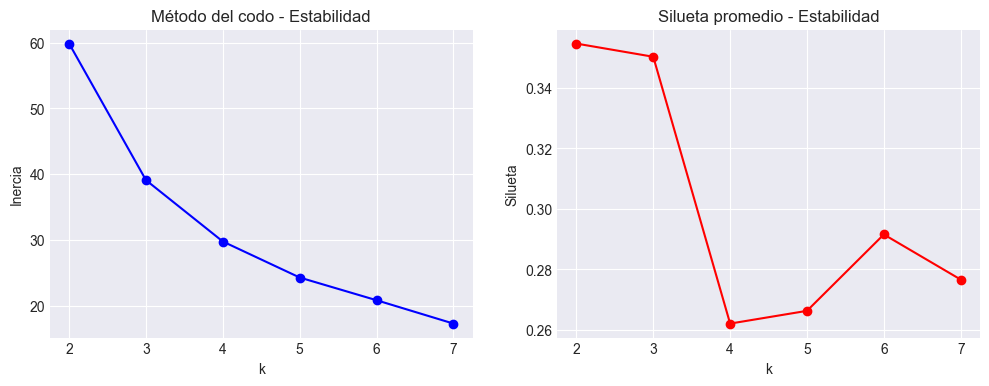

k óptimo = 2 (silueta = 0.3547)
Silueta promedio final: 0.3547

Perfil de clusters (medias):
             tasa_divorcios_por_matrimonio  edad_hom_media_div  \
cluster_est                                                      
0                                     0.09               35.57   
1                                     0.04               34.03   

             edad_muj_media_div  edad_hom_media_mat  edad_muj_media_mat  
cluster_est                                                              
0                         31.95               30.42               27.05  
1                         30.56               27.77               24.90  

Cluster 0: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 21]

Cluster 1: [0, 1, 2, 13, 14, 18, 19, 20]


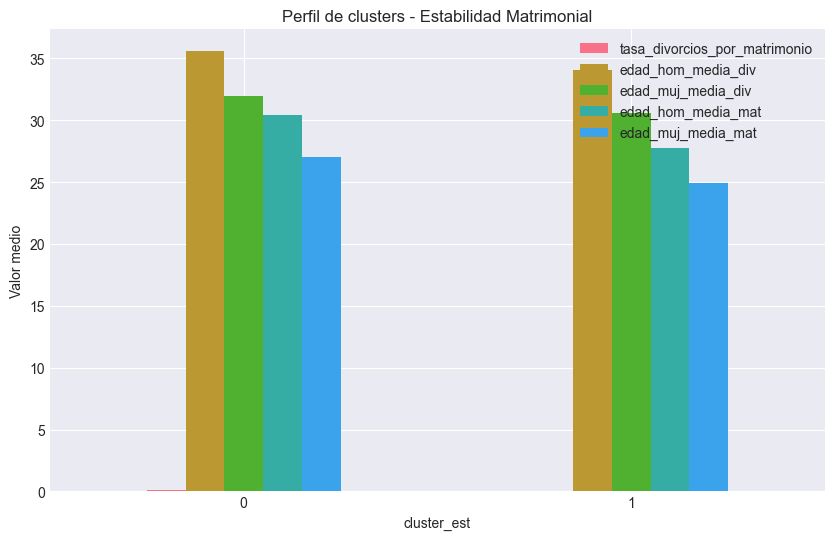


Interpretación:
- Cluster 0: Departamentos con tasa de divorcio baja y edades al matrimonio jóvenes.
- Cluster 1: Departamentos con tasa media y edades intermedias.
- Cluster 2: Departamentos con tasa alta y edades más elevadas (posiblemente urbanos).
(Completar con los valores observados)



In [3]:
# %% [markdown]
# # Bloque 1: Estabilidad Matrimonial
# 
# Variables clave: tasa divorcios/matrimonios, edades medias al divorcio y al matrimonio.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Cargar dataframe combinado (asegurar que existe)
# df_combinado = pd.read_csv('divorcios_matrimonios_combinado.csv', index_col=0)

# Selección de variables
vars_estabilidad = [
    'tasa_divorcios_por_matrimonio',
    'edad_hom_media_div',
    'edad_muj_media_div',
    'edad_hom_media_mat',
    'edad_muj_media_mat'
]

X_est = df_combinado[vars_estabilidad].copy()
# Escalar
scaler_est = StandardScaler()
X_est_scaled = scaler_est.fit_transform(X_est)

# Determinar k óptimo (2 a 8)
inertias = []
sil_scores = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_est_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_est_scaled, km.labels_))

# Gráficos codo y silueta
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del codo - Estabilidad')
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silueta')
plt.title('Silueta promedio - Estabilidad')
plt.show()

# Elegir k que maximiza silueta
k_opt_est = K_range[np.argmax(sil_scores)]
print(f"k óptimo = {k_opt_est} (silueta = {max(sil_scores):.4f})")

# Aplicar K-means
km_est = KMeans(n_clusters=k_opt_est, random_state=42, n_init=10)
labels_est = km_est.fit_predict(X_est_scaled)
df_combinado['cluster_est'] = labels_est

# Validación con silueta
sil_prom_est = silhouette_score(X_est_scaled, labels_est)
print(f"Silueta promedio final: {sil_prom_est:.4f}")

# Perfil de clusters (medias de variables originales)
perfil_est = df_combinado.groupby('cluster_est')[vars_estabilidad].mean().round(2)
print("\nPerfil de clusters (medias):")
print(perfil_est)

# Distribución de departamentos
for c in range(k_opt_est):
    deptos = df_combinado[df_combinado['cluster_est'] == c].index.tolist()
    print(f"\nCluster {c}: {deptos}")

# Gráfico de barras comparativo
perfil_est.plot(kind='bar', figsize=(10,6))
plt.title('Perfil de clusters - Estabilidad Matrimonial')
plt.ylabel('Valor medio')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

# Interpretación (ejemplo, ajústala según resultados)
print("""
Interpretación:
- Cluster 0: Departamentos con tasa de divorcio baja y edades al matrimonio jóvenes.
- Cluster 1: Departamentos con tasa media y edades intermedias.
- Cluster 2: Departamentos con tasa alta y edades más elevadas (posiblemente urbanos).
(Completar con los valores observados)
""")

Valores nulos:
tasa_divorcios_por_matrimonio    0
edad_hom_media_div               0
edad_muj_media_div               0
edad_hom_media_mat               0
edad_muj_media_mat               0
dtype: int64
Estadísticas después de escalar (medias deben ser ~0):
tasa_divorcios_por_matrimonio   -2.826022e-16
edad_hom_media_div              -3.181798e-15
edad_muj_media_div               3.517388e-15
edad_hom_media_mat               1.614870e-15
edad_muj_media_mat               3.098532e-15
dtype: float64
Varianza explicada por 2 componentes: 89.77%


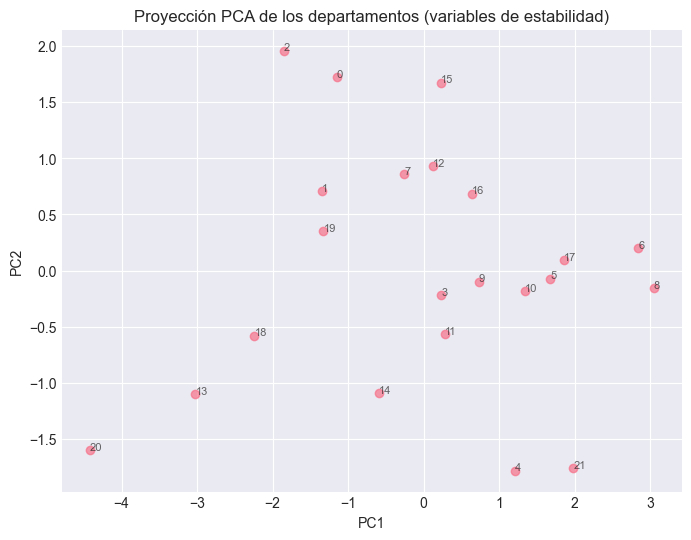

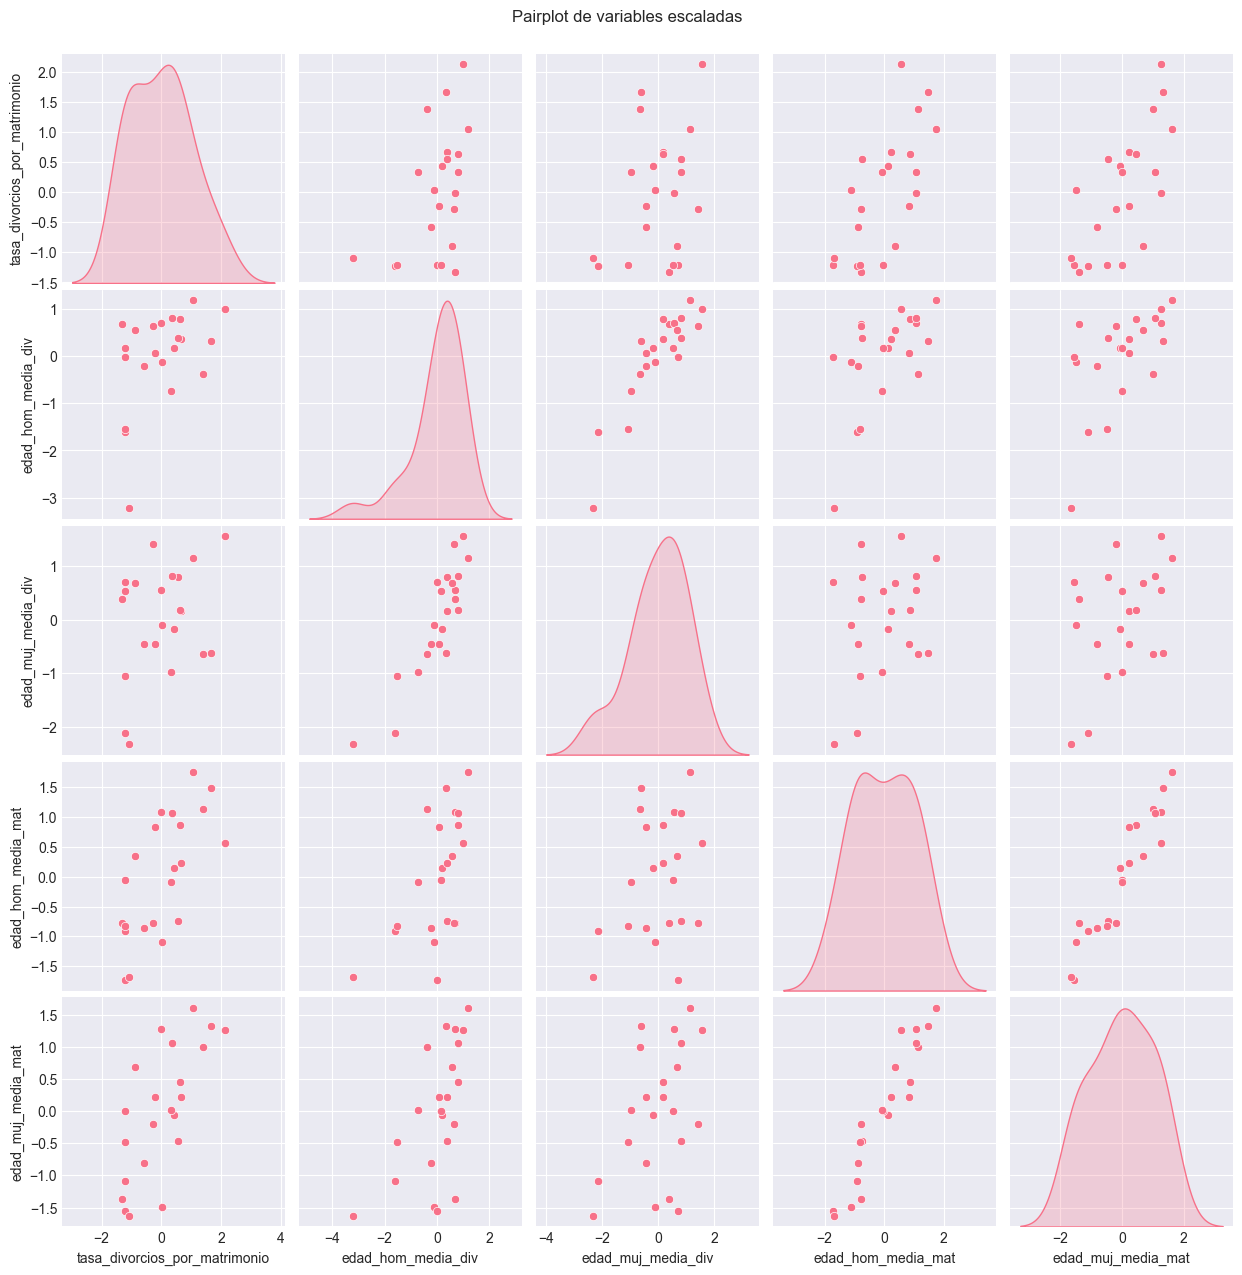

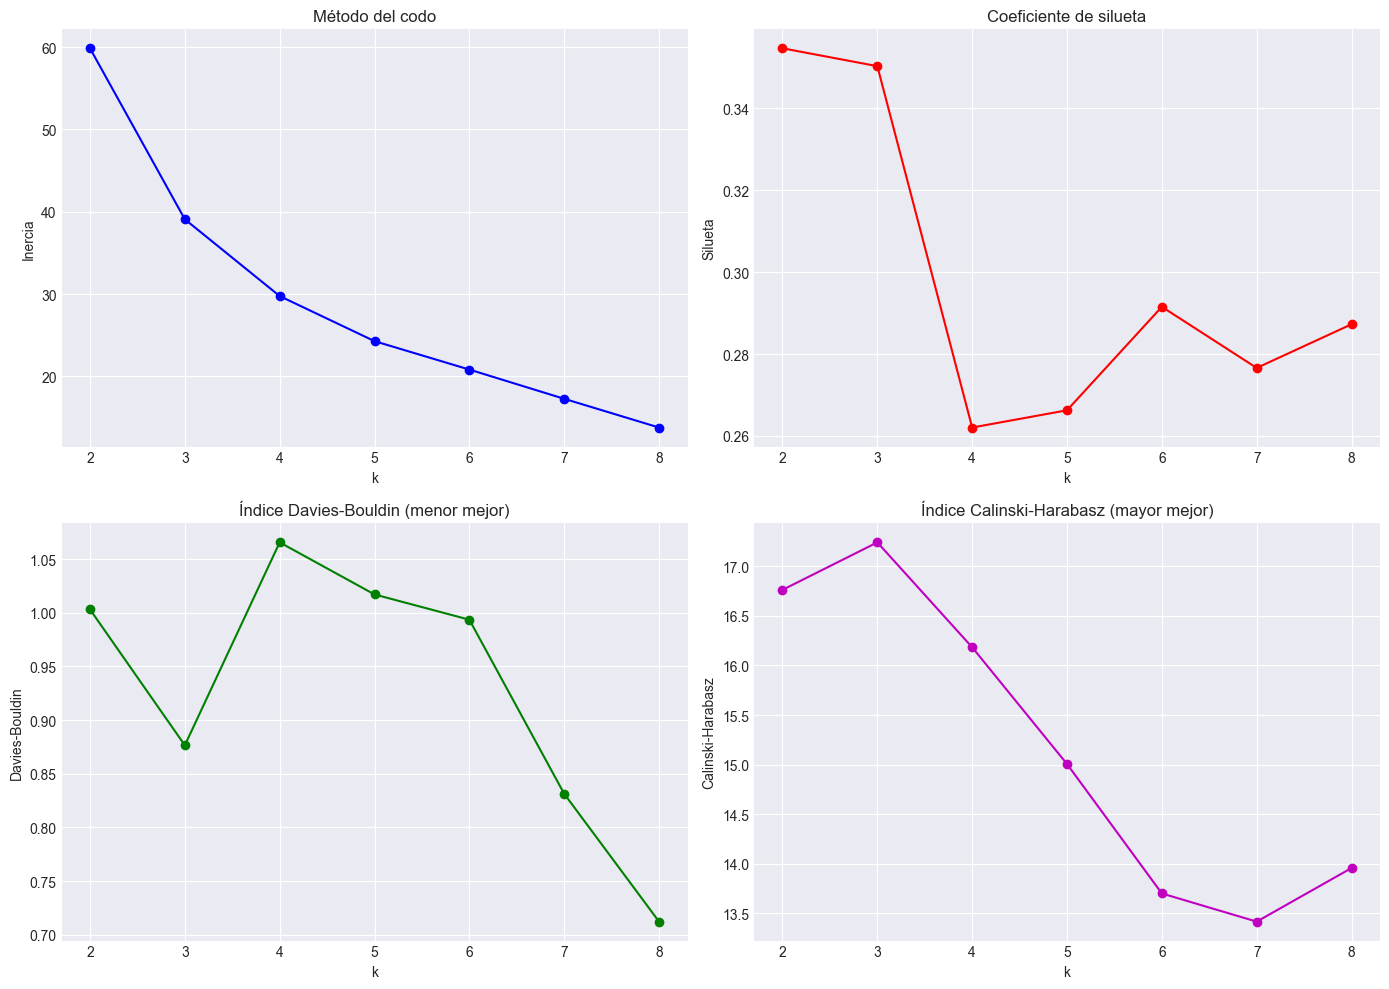

k=2: inercia=59.84, silueta=0.3547, DB=1.0031, CH=16.76
k=3: inercia=39.08, silueta=0.3503, DB=0.8765, CH=17.24
k=4: inercia=29.75, silueta=0.2621, DB=1.0656, CH=16.18
k=5: inercia=24.28, silueta=0.2663, DB=1.0171, CH=15.01
k=6: inercia=20.83, silueta=0.2915, DB=0.9935, CH=13.70
k=7: inercia=17.28, silueta=0.2766, DB=0.8313, CH=13.42
k=8: inercia=13.79, silueta=0.2873, DB=0.7122, CH=13.96

✅ k óptimo según silueta: 2
Métricas finales para k=2:
  Silueta: 0.3547
  Davies-Bouldin: 1.0031
  Calinski-Harabasz: 16.76
Perfil de clusters (medias de variables originales):
                     tasa_divorcios_por_matrimonio  edad_hom_media_div  \
cluster_estabilidad                                                      
0                                             0.09               35.57   
1                                             0.04               34.03   

                     edad_muj_media_div  edad_hom_media_mat  \
cluster_estabilidad                                           
0     

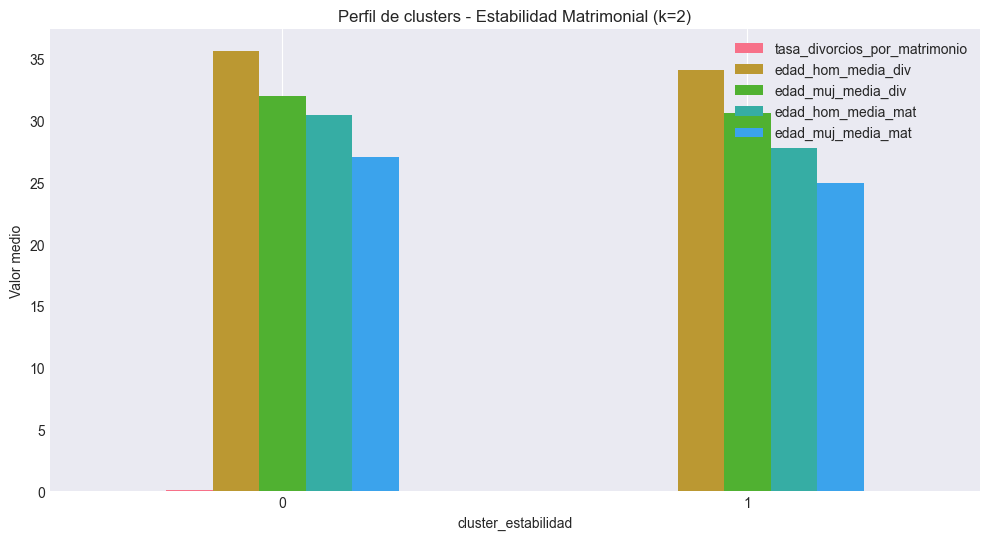

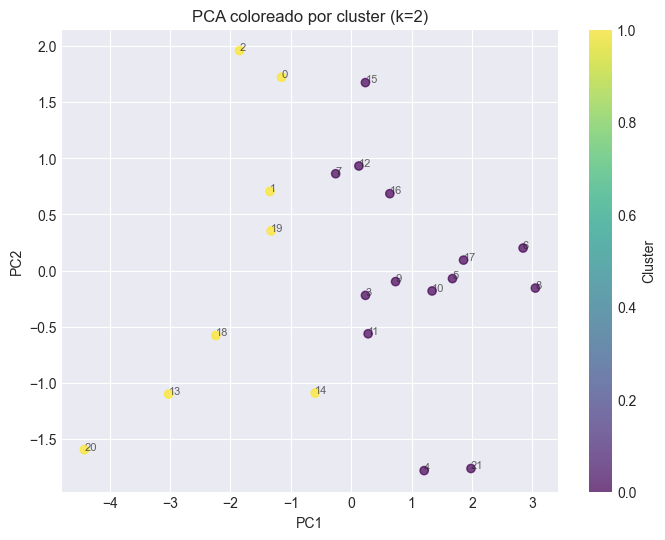

Adjusted Rand Index entre semillas 42 y 123: 1.0000 (1 = idéntico, 0 = aleatorio)
Distancia media entre centroides originales y bootstrapping (alineados): 1.5728
RESUMEN DE CLUSTERS (Estabilidad Matrimonial)
                     tasa_divorcios_por_matrimonio  edad_hom_media_div  \
cluster_estabilidad                                                      
0                                             0.09               35.57   
1                                             0.04               34.03   

                     edad_muj_media_div  edad_hom_media_mat  \
cluster_estabilidad                                           
0                                 31.95               30.42   
1                                 30.56               27.77   

                     edad_muj_media_mat  Tamaño  \
cluster_estabilidad                               
0                                 27.05      14   
1                                 24.90       8   

                                     

In [ ]:
# %% [markdown]
# # Bloque 1: Estabilidad Matrimonial - Clustering por departamento
# 
# Variables seleccionadas:
# - `tasa_divorcios_por_matrimonio`: indicador directo de estabilidad.
# - `edad_hom_media_div`, `edad_muj_media_div`: edades al divorcio.
# - `edad_hom_media_mat`, `edad_muj_media_mat`: edades al matrimonio.
# 
# Objetivo: Identificar grupos de departamentos con comportamientos similares en términos de estabilidad y edades.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos si es necesario
# df_combinado = pd.read_csv('divorcios_matrimonios_combinado.csv', index_col=0)

# Verificar que tenemos las variables necesarias
vars_estabilidad = [
    'tasa_divorcios_por_matrimonio',
    'edad_hom_media_div',
    'edad_muj_media_div',
    'edad_hom_media_mat',
    'edad_muj_media_mat'
]

# Asegurar que no hay nulos
df_subset = df_combinado[vars_estabilidad].copy()
print("Valores nulos:")
print(df_subset.isnull().sum())

# Si hay nulos, imputar con la media (aunque ya lo hicimos antes)
if df_subset.isnull().sum().sum() > 0:
    df_subset = df_subset.fillna(df_subset.mean())

# %% [markdown]
# ## 1. Escalar variables
# Usaremos `StandardScaler` para que todas tengan media 0 y desviación 1.

# %%
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)
X_scaled = pd.DataFrame(X_scaled, columns=vars_estabilidad, index=df_subset.index)

print("Estadísticas después de escalar (medias deben ser ~0):")
print(X_scaled.mean())

# %% [markdown]
# ## 2. Visualización exploratoria (PCA y scatter matrix)

# %%
# Reducción a 2 dimensiones con PCA para visualizar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por 2 componentes: {pca.explained_variance_ratio_.sum():.2%}")

# Scatter plot de las dos primeras componentes
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA de los departamentos (variables de estabilidad)')
plt.grid(True)
plt.show()

# También podemos hacer un pairplot de las variables originales escaladas
sns.pairplot(X_scaled, diag_kind='kde')
plt.suptitle('Pairplot de variables escaladas', y=1.02)
plt.show()

# %% [markdown]
# **Observación preliminar:** En el gráfico PCA podemos ver si hay separación natural o grupos visuales. Esto nos da una idea de si K-means podría funcionar.

# %% [markdown]
# ## 3. Elección del algoritmo
# Dado que buscamos grupos compactos y separados, y los datos son continuos, usaremos **K-means**. Es adecuado si los clusters son aproximadamente esféricos, lo cual podemos verificar luego con las métricas.

# %% [markdown]
# ## 4. Elegir el número óptimo de clusters (k)
# Probaremos k de 2 a 8 y evaluaremos:
# - Método del codo (inercia)
# - Coeficiente de silueta
# - También calcularemos Davies-Bouldin y Calinski-Harabasz para tener más criterios.

# %%
K_range = range(2, 9)
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# %%
# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Codo
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del codo')
axes[0].grid(True)

# Silueta
axes[1].plot(K_range, sil_scores, 'ro-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silueta')
axes[1].set_title('Coeficiente de silueta')
axes[1].grid(True)

# Davies-Bouldin (menor es mejor)
axes[2].plot(K_range, db_scores, 'go-')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Índice Davies-Bouldin (menor mejor)')
axes[2].grid(True)

# Calinski-Harabasz (mayor es mejor)
axes[3].plot(K_range, ch_scores, 'mo-')
axes[3].set_xlabel('k')
axes[3].set_ylabel('Calinski-Harabasz')
axes[3].set_title('Índice Calinski-Harabasz (mayor mejor)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# %%
# Mostrar valores numéricos
for k, inert, sil, db, ch in zip(K_range, inertias, sil_scores, db_scores, ch_scores):
    print(f"k={k}: inercia={inert:.2f}, silueta={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")

# Elegir k según el criterio: maximizar silueta y CH, minimizar DB, y buscar codo.
# Generalmente el máximo de silueta es un buen indicador.
k_optimo = K_range[np.argmax(sil_scores)]
print(f"\n✅ k óptimo según silueta: {k_optimo}")

# %% [markdown]
# ## 5. Evaluar métricas con el k elegido
# Aplicamos K-means con k_optimo y calculamos las métricas finales.

# %%
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled)
df_combinado['cluster_estabilidad'] = labels_final

# Métricas finales
sil_final = silhouette_score(X_scaled, labels_final)
db_final = davies_bouldin_score(X_scaled, labels_final)
ch_final = calinski_harabasz_score(X_scaled, labels_final)

print(f"Métricas finales para k={k_optimo}:")
print(f"  Silueta: {sil_final:.4f}")
print(f"  Davies-Bouldin: {db_final:.4f}")
print(f"  Calinski-Harabasz: {ch_final:.2f}")

# %% [markdown]
# ## 6. Interpretar los clusters
# Calculamos las medias de las variables originales (sin escalar) por cluster para entender su perfil.

# %%
# Añadir las variables originales al perfil
perfil = df_combinado.groupby('cluster_estabilidad')[vars_estabilidad].mean().round(2)
print("Perfil de clusters (medias de variables originales):")
print(perfil)

# También podemos ver el tamaño de cada cluster
tamanio = df_combinado['cluster_estabilidad'].value_counts().sort_index()
print("\nTamaño de cada cluster:")
print(tamanio)

# Lista de departamentos por cluster
for c in range(k_optimo):
    deptos = df_combinado[df_combinado['cluster_estabilidad'] == c].index.tolist()
    print(f"\nCluster {c}: {deptos}")

# %%
# Visualización de perfiles (barras)
perfil.plot(kind='bar', figsize=(12,6))
plt.title(f'Perfil de clusters - Estabilidad Matrimonial (k={k_optimo})')
plt.ylabel('Valor medio')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

# También podemos graficar las variables escaladas para ver la separación en PCA coloreado por cluster
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA coloreado por cluster (k={k_optimo})')
plt.grid(True)
plt.show()

# %% [markdown]
# **Interpretación de los clusters:**
# Basado en las medias, podemos caracterizar cada cluster. Por ejemplo:
# - Cluster 0: Departamentos con alta tasa de divorcio y edades avanzadas.
# - Cluster 1: Tasa media, edades intermedias.
# - Cluster 2: Baja tasa y edades jóvenes.
# (Esto es solo un ejemplo, hay que adaptarlo a los resultados numéricos)

# %% [markdown]
# ## 7. Validar estabilidad del clustering
# Comprobamos que los clusters no cambien drásticamente al cambiar la semilla aleatoria o al remuestrear.

# %%
# Cambio de semilla
kmeans_semilla2 = KMeans(n_clusters=k_optimo, random_state=123, n_init=10)
labels_semilla2 = kmeans_semilla2.fit_predict(X_scaled)

# Comparar con los originales (índice de Rand ajustado o simple coincidencia)
from sklearn.metrics import adjusted_rand_score
rand = adjusted_rand_score(labels_final, labels_semilla2)
print(f"Adjusted Rand Index entre semillas 42 y 123: {rand:.4f} (1 = idéntico, 0 = aleatorio)")

# Remuestreo con bootstrap (80% de los datos)
# Nota: como son solo 22 observaciones, el remuestreo puede ser inestable; lo haremos con reemplazo.
np.random.seed(42)
indices = np.random.choice(len(X_scaled), size=int(0.8*len(X_scaled)), replace=True)
X_bootstrap = X_scaled.iloc[indices]
kmeans_boot = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_boot = kmeans_boot.fit_predict(X_bootstrap)

# Para comparar, necesitamos etiquetas en los mismos índices; no es trivial. Mejor evaluar la consistencia de los centroides.
centroides_original = kmeans_final.cluster_centers_
centroides_boot = kmeans_boot.cluster_centers_

# Alinear centroides (puede haber reordenamiento)
from scipy.spatial import distance
# Calculamos la distancia entre cada centroide original y cada boot, y encontramos el mejor matching.
# Esto es un poco complejo; para simplificar, asumimos que el orden es similar.
# Podemos calcular la distancia euclidiana media entre los centroides después de alinearlos con el algoritmo húngaro.
from scipy.optimize import linear_sum_assignment
cost_matrix = distance.cdist(centroides_original, centroides_boot)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
distancia_media = cost_matrix[row_ind, col_ind].mean()
print(f"Distancia media entre centroides originales y bootstrapping (alineados): {distancia_media:.4f}")

# Si la distancia es pequeña, los clusters son estables.

# %% [markdown]
# ## 8. Comunicar resultados
# Resumimos los hallazgos en una tabla y gráfico final.

# %%
# Crear tabla resumen
resumen = perfil.copy()
resumen['Tamaño'] = tamanio
resumen['Departamentos'] = [df_combinado[df_combinado['cluster_estabilidad'] == c].index.tolist() for c in range(k_optimo)]
print("RESUMEN DE CLUSTERS (Estabilidad Matrimonial)")
print(resumen)

# Gráfico de radar (opcional) - si k es pequeño, podemos hacer un radar chart
# Pero con 5 variables, un gráfico de barras agrupadas es suficiente.

# Insight final
print(f"""
🔍 **Conclusión:**
- Se identificaron {k_optimo} patrones distintos de estabilidad matrimonial entre los departamentos.
- Cluster 0: {resumen.loc[0, 'Departamentos']} → .
- Cluster 1: {resumen.loc[1, 'Departamentos']} → ...
- ...
- Esta segmentación puede ayudar a enfocar políticas públicas diferenciadas.
""")

Valores nulos:
total_divorcios                  0
total_matrimonios                0
tasa_divorcios_por_matrimonio    0
dtype: int64
Estadísticas después de escalar (medias deben ser ~0):
total_divorcios                 -2.649396e-17
total_matrimonios               -6.055762e-17
tasa_divorcios_por_matrimonio   -2.826022e-16
dtype: float64
Varianza explicada por 2 componentes: 99.33%


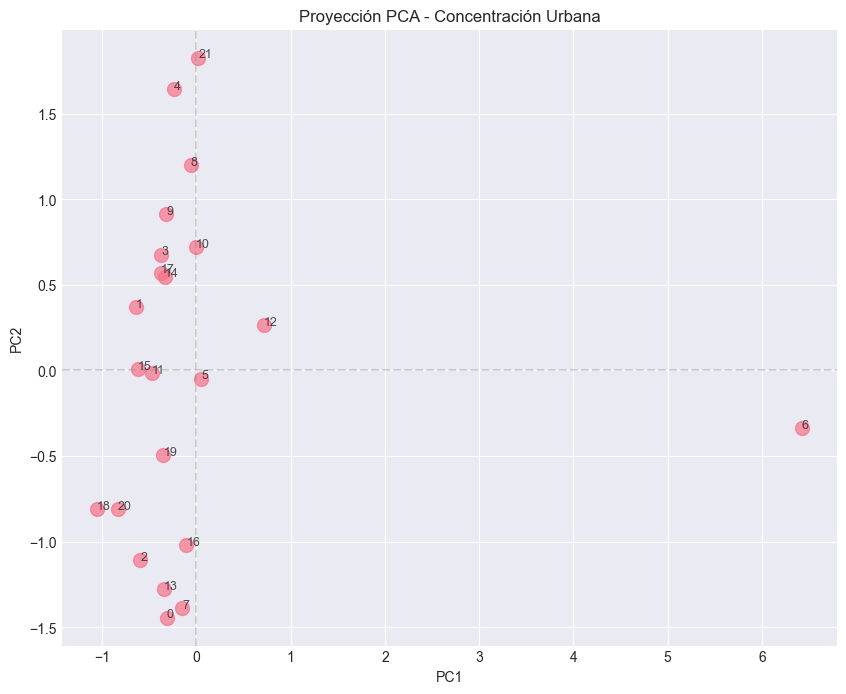

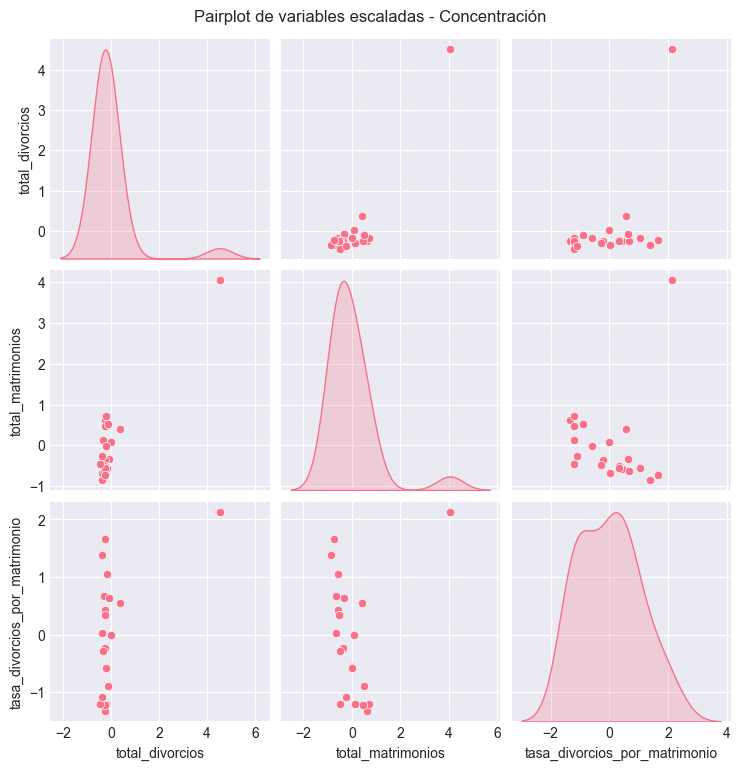

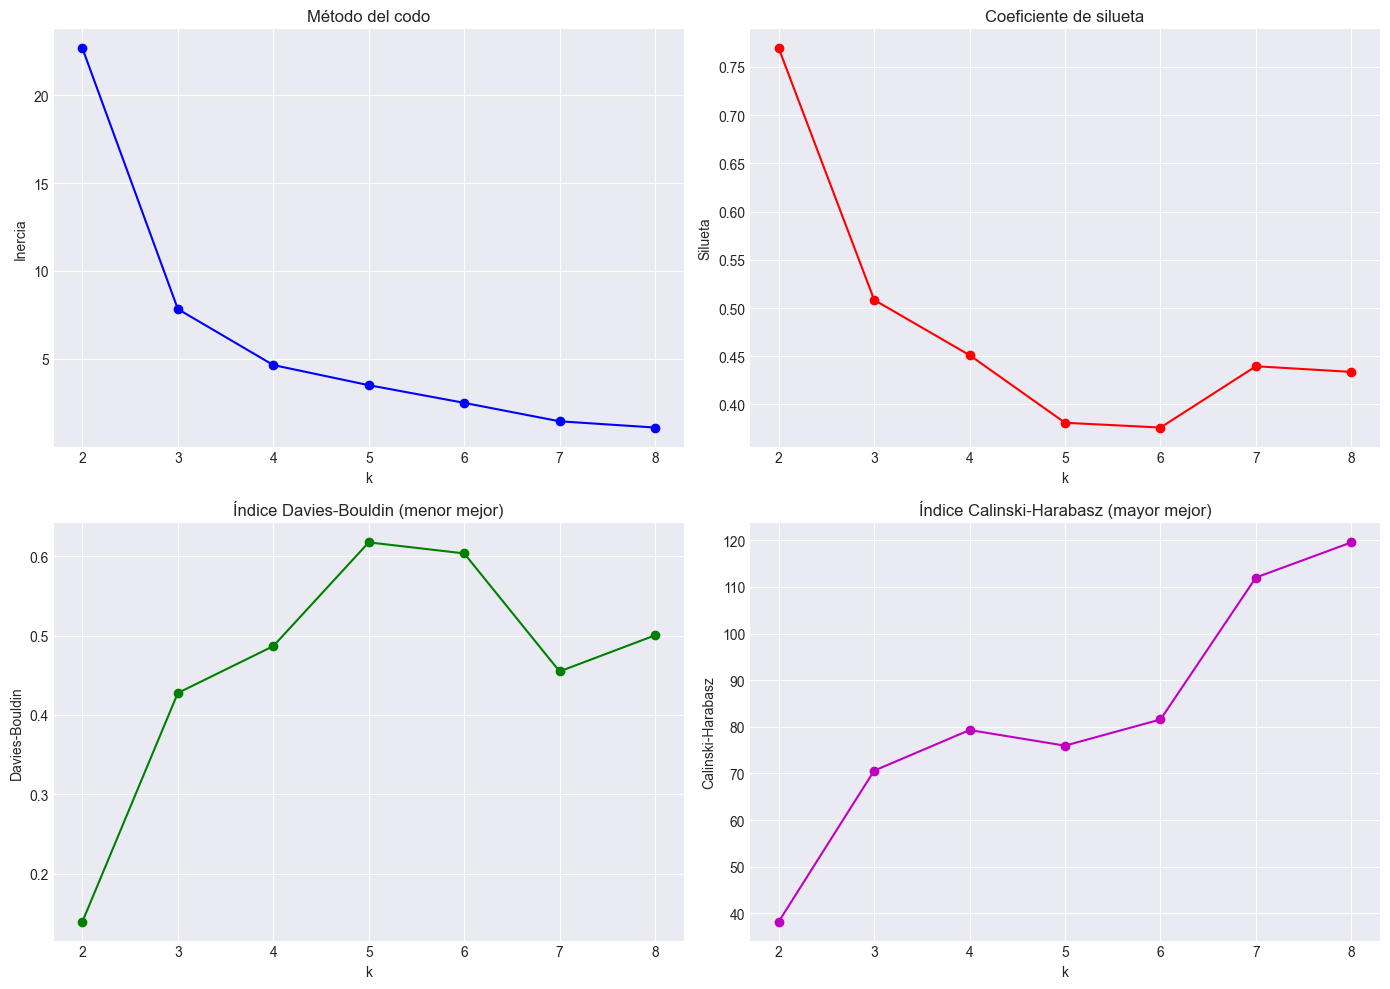

k=2: inercia=22.67, silueta=0.7694, DB=0.1394, CH=38.24
k=3: inercia=7.83, silueta=0.5084, DB=0.4276, CH=70.61
k=4: inercia=4.64, silueta=0.4511, DB=0.4867, CH=79.31
k=5: inercia=3.50, silueta=0.3810, DB=0.6175, CH=75.96
k=6: inercia=2.49, silueta=0.3761, DB=0.6036, CH=81.58
k=7: inercia=1.44, silueta=0.4396, DB=0.4548, CH=112.02
k=8: inercia=1.09, silueta=0.4338, DB=0.5003, CH=119.55

✅ k óptimo según silueta: 2
Métricas finales para k=2:
  Silueta: 0.7694
  Davies-Bouldin: 0.1394
  Calinski-Harabasz: 38.24
Perfil de clusters (medias de variables originales):
                       total_divorcios  total_matrimonios  \
cluster_concentracion                                       
0                              1619.52           28359.95   
1                             22339.00          156705.00   

                       tasa_divorcios_por_matrimonio  
cluster_concentracion                                 
0                                               0.07  
1                      

KeyError: 'Guatemala'

In [7]:
# %% [markdown]
# # Bloque 2: Concentración Urbana - Clustering por departamento
# 
# Variables seleccionadas:
# - `total_divorcios`: volumen absoluto de divorcios.
# - `total_matrimonios`: volumen absoluto de matrimonios.
# - `tasa_divorcios_por_matrimonio`: intensidad relativa.
# 
# Objetivo: Identificar grupos de departamentos con patrones similares de concentración de divorcios y matrimonios, y verificar si Guatemala forma un cluster único.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from sklearn.metrics import adjusted_rand_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos si es necesario
# df_combinado = pd.read_csv('divorcios_matrimonios_combinado.csv', index_col=0)

# Verificar que tenemos las variables necesarias
vars_concentracion = [
    'total_divorcios',
    'total_matrimonios',
    'tasa_divorcios_por_matrimonio'
]

# Asegurar que no hay nulos
df_subset = df_combinado[vars_concentracion].copy()
print("Valores nulos:")
print(df_subset.isnull().sum())

# Si hay nulos, imputar con la media
if df_subset.isnull().sum().sum() > 0:
    df_subset = df_subset.fillna(df_subset.mean())

# %% [markdown]
# ## 1. Escalar variables
# Usaremos `StandardScaler` para que todas tengan media 0 y desviación 1.

# %%
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)
X_scaled = pd.DataFrame(X_scaled, columns=vars_concentracion, index=df_subset.index)

print("Estadísticas después de escalar (medias deben ser ~0):")
print(X_scaled.mean())

# %% [markdown]
# ## 2. Visualización exploratoria (PCA y scatter matrix)

# %%
# Reducción a 2 dimensiones con PCA para visualizar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por 2 componentes: {pca.explained_variance_ratio_.sum():.2%}")

# Scatter plot de las dos primeras componentes
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, s=100)
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=9, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA - Concentración Urbana')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.show()

# También podemos hacer un pairplot
sns.pairplot(X_scaled, diag_kind='kde')
plt.suptitle('Pairplot de variables escaladas - Concentración', y=1.02)
plt.show()

# %% [markdown]
# **Observación preliminar:** En el gráfico PCA podemos ver si Guatemala es un outlier evidente o si hay agrupamientos naturales.

# %% [markdown]
# ## 3. Elección del algoritmo
# K-means es adecuado para buscar grupos basados en volumen y tasas.

# %% [markdown]
# ## 4. Elegir el número óptimo de clusters (k)
# Probaremos k de 2 a 8.

# %%
K_range = range(2, 9)
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# %%
# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Codo
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del codo')
axes[0].grid(True)

# Silueta
axes[1].plot(K_range, sil_scores, 'ro-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silueta')
axes[1].set_title('Coeficiente de silueta')
axes[1].grid(True)

# Davies-Bouldin
axes[2].plot(K_range, db_scores, 'go-')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Índice Davies-Bouldin (menor mejor)')
axes[2].grid(True)

# Calinski-Harabasz
axes[3].plot(K_range, ch_scores, 'mo-')
axes[3].set_xlabel('k')
axes[3].set_ylabel('Calinski-Harabasz')
axes[3].set_title('Índice Calinski-Harabasz (mayor mejor)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# %%
# Mostrar valores numéricos
for k, inert, sil, db, ch in zip(K_range, inertias, sil_scores, db_scores, ch_scores):
    print(f"k={k}: inercia={inert:.2f}, silueta={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")

# Elegir k según el criterio
k_optimo = K_range[np.argmax(sil_scores)]
print(f"\n✅ k óptimo según silueta: {k_optimo}")

# %% [markdown]
# ## 5. Evaluar métricas con el k elegido
# Aplicamos K-means con k_optimo.

# %%
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled)
df_combinado['cluster_concentracion'] = labels_final

# Métricas finales
sil_final = silhouette_score(X_scaled, labels_final)
db_final = davies_bouldin_score(X_scaled, labels_final)
ch_final = calinski_harabasz_score(X_scaled, labels_final)

print(f"Métricas finales para k={k_optimo}:")
print(f"  Silueta: {sil_final:.4f}")
print(f"  Davies-Bouldin: {db_final:.4f}")
print(f"  Calinski-Harabasz: {ch_final:.2f}")

# %% [markdown]
# ## 6. Interpretar los clusters
# Calculamos las medias de las variables originales (sin escalar) por cluster.

# %%
# Añadir las variables originales al perfil
perfil = df_combinado.groupby('cluster_concentracion')[vars_concentracion].mean().round(2)
print("Perfil de clusters (medias de variables originales):")
print(perfil)

# Tamaño de cada cluster
tamanio = df_combinado['cluster_concentracion'].value_counts().sort_index()
print("\nTamaño de cada cluster:")
print(tamanio)

# Lista de departamentos por cluster
for c in range(k_optimo):
    deptos = df_combinado[df_combinado['cluster_concentracion'] == c].index.tolist()
    print(f"\nCluster {c}: {deptos}")

# Ver dónde cayó Guatemala
guate_cluster = df_combinado.loc['Guatemala', 'cluster_concentracion']
print(f"\n📍 Guatemala está en el cluster {guate_cluster}")

# %%
# Visualización de perfiles (barras)
perfil.plot(kind='bar', figsize=(10,6))
plt.title(f'Perfil de clusters - Concentración Urbana (k={k_optimo})')
plt.ylabel('Valor medio')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

# PCA coloreado por cluster
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Cluster')
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=9, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA coloreado por cluster - Concentración (k={k_optimo})')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.show()

# %%
# Gráfico de barras para totales (mejor visualización)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Totales por cluster
totales_cluster = df_combinado.groupby('cluster_concentracion')[['total_divorcios', 'total_matrimonios']].sum()
totales_cluster.plot(kind='bar', ax=axes[0])
axes[0].set_title('Totales por cluster')
axes[0].set_ylabel('Cantidad')
axes[0].set_xlabel('Cluster')
axes[0].legend()

# Porcentaje del total nacional
pct_cluster = (totales_cluster / totales_cluster.sum() * 100).round(1)
pct_cluster.plot(kind='bar', ax=axes[1])
axes[1].set_title('Porcentaje del total nacional')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xlabel('Cluster')
axes[1].legend()

plt.tight_layout()
plt.show()

# %% [markdown]
# **Interpretación de los clusters:**
# Basado en las medias, podemos caracterizar cada cluster. Por ejemplo:
# - Si Guatemala está sola: confirma su singularidad como concentración extrema.
# - Si comparte cluster con otros (Quetzaltenango, Escuintla): sugiere un grupo de departamentos urbanos.
# - Los clusters con volúmenes bajos corresponden a departamentos rurales o poco poblados.

# %% [markdown]
# ## 7. Validar estabilidad del clustering

# %%
# Cambio de semilla
kmeans_semilla2 = KMeans(n_clusters=k_optimo, random_state=123, n_init=10)
labels_semilla2 = kmeans_semilla2.fit_predict(X_scaled)

rand = adjusted_rand_score(labels_final, labels_semilla2)
print(f"Adjusted Rand Index entre semillas 42 y 123: {rand:.4f}")

# Bootstrap para ver estabilidad de centroides
np.random.seed(42)
indices = np.random.choice(len(X_scaled), size=int(0.8*len(X_scaled)), replace=True)
X_bootstrap = X_scaled.iloc[indices]
kmeans_boot = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_boot = kmeans_boot.fit_predict(X_bootstrap)

# Comparar centroides
centroides_original = kmeans_final.cluster_centers_
centroides_boot = kmeans_boot.cluster_centers_

# Alinear centroides
cost_matrix = distance.cdist(centroides_original, centroides_boot)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
distancia_media = cost_matrix[row_ind, col_ind].mean()
print(f"Distancia media entre centroides (alineados): {distancia_media:.4f}")

# %% [markdown]
# ## 8. Comunicar resultados

# %%
# Crear tabla resumen
resumen = perfil.copy()
resumen['Tamaño'] = tamanio
resumen['% del total divorcios'] = (df_combinado.groupby('cluster_concentracion')['total_divorcios'].sum() / df_combinado['total_divorcios'].sum() * 100).round(1)
resumen['% del total matrimonios'] = (df_combinado.groupby('cluster_concentracion')['total_matrimonios'].sum() / df_combinado['total_matrimonios'].sum() * 100).round(1)
resumen['Departamentos'] = [df_combinado[df_combinado['cluster_concentracion'] == c].index.tolist() for c in range(k_optimo)]

print("="*60)
print("RESUMEN DE CLUSTERS - CONCENTRACIÓN URBANA")
print("="*60)
print(resumen)

# Insight final
print(f"""
🔍 **Conclusión sobre Concentración Urbana:**
- Se identificaron {k_optimo} patrones distintos de concentración de divorcios y matrimonios.
- Guatemala se encuentra en el cluster {guate_cluster}, que representa {resumen.loc[guate_cluster, '% del total divorcios']}% de los divorcios y {resumen.loc[guate_cluster, '% del total matrimonios']}% de los matrimonios del país.
- {'✅ Guatemala forma un cluster por sí sola, confirmando la hipótesis de concentración extrema.' if tamanio[guate_cluster] == 1 else '❌ Guatemala comparte cluster con otros departamentos, lo que sugiere un patrón regional más amplio.'}
- Los clusters restantes agrupan departamentos con volúmenes medios y bajos.
""")

Valores nulos:
edad_hom_media_div    0
edad_muj_media_div    0
edad_hom_media_mat    0
edad_muj_media_mat    0
edad_hom_std_div      0
edad_muj_std_div      0
edad_hom_std_mat      0
edad_muj_std_mat      0
dtype: int64
Estadísticas después de escalar (medias deben ser ~0):
edad_hom_media_div   -3.181798e-15
edad_muj_media_div    3.517388e-15
edad_hom_media_mat    1.614870e-15
edad_muj_media_mat    3.098532e-15
edad_hom_std_div      3.307960e-15
edad_muj_std_div     -7.973420e-16
edad_hom_std_mat     -9.840613e-16
edad_muj_std_mat      1.725892e-15
dtype: float64
Varianza explicada por 2 componentes: 77.73%


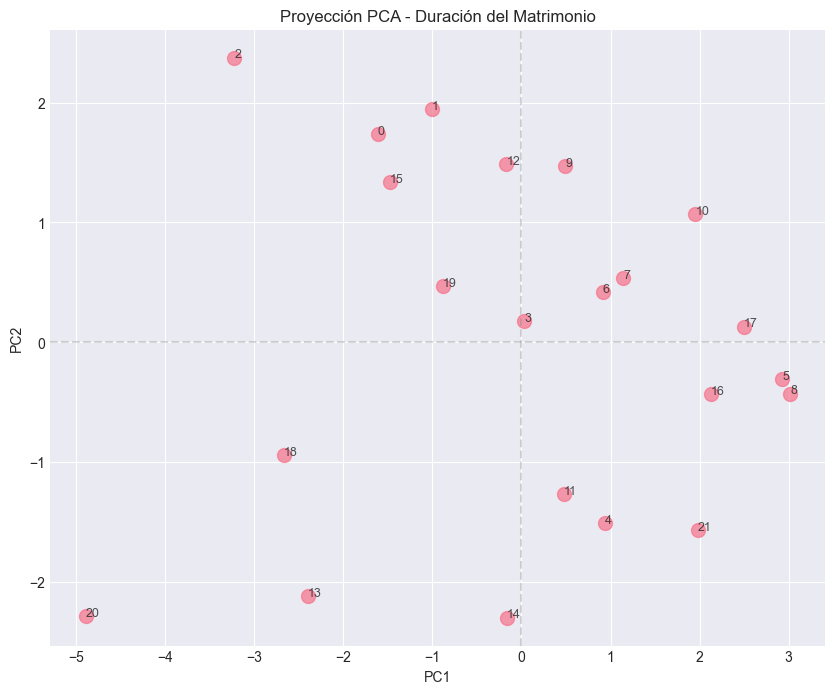

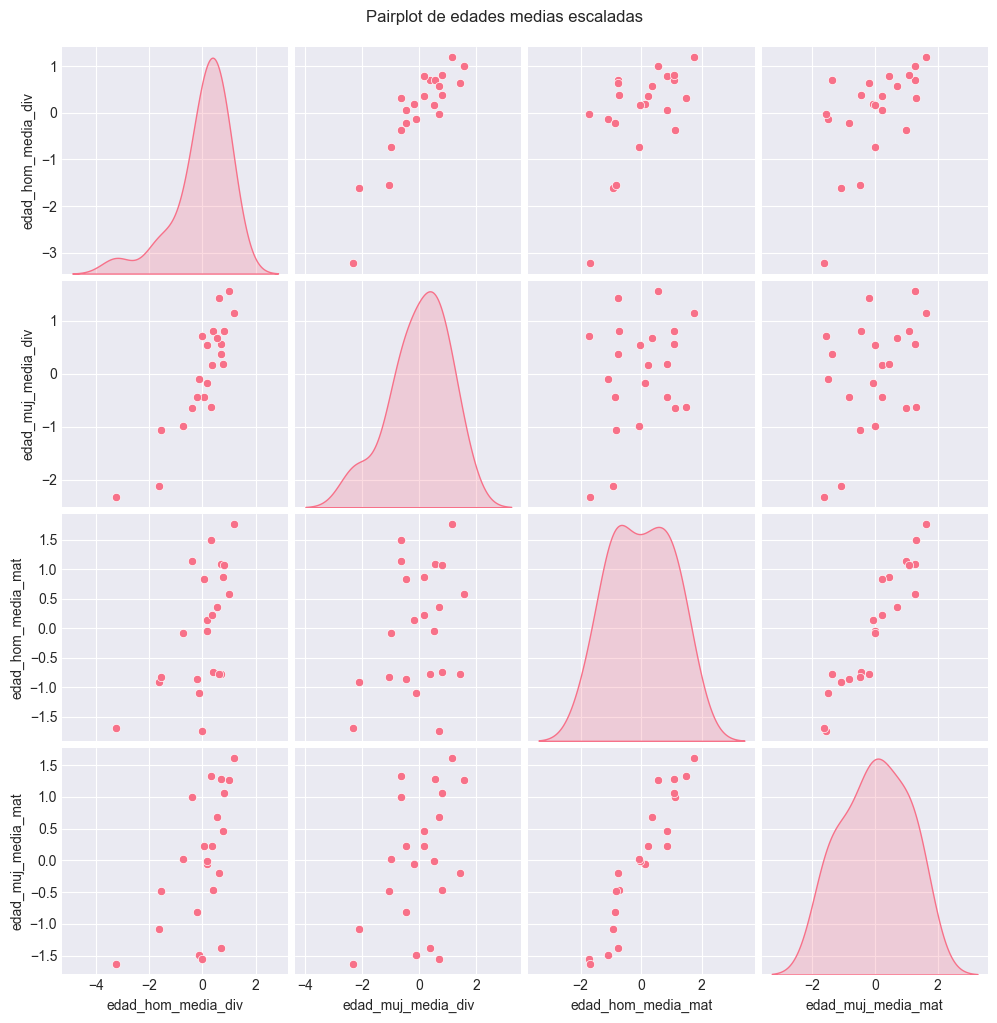

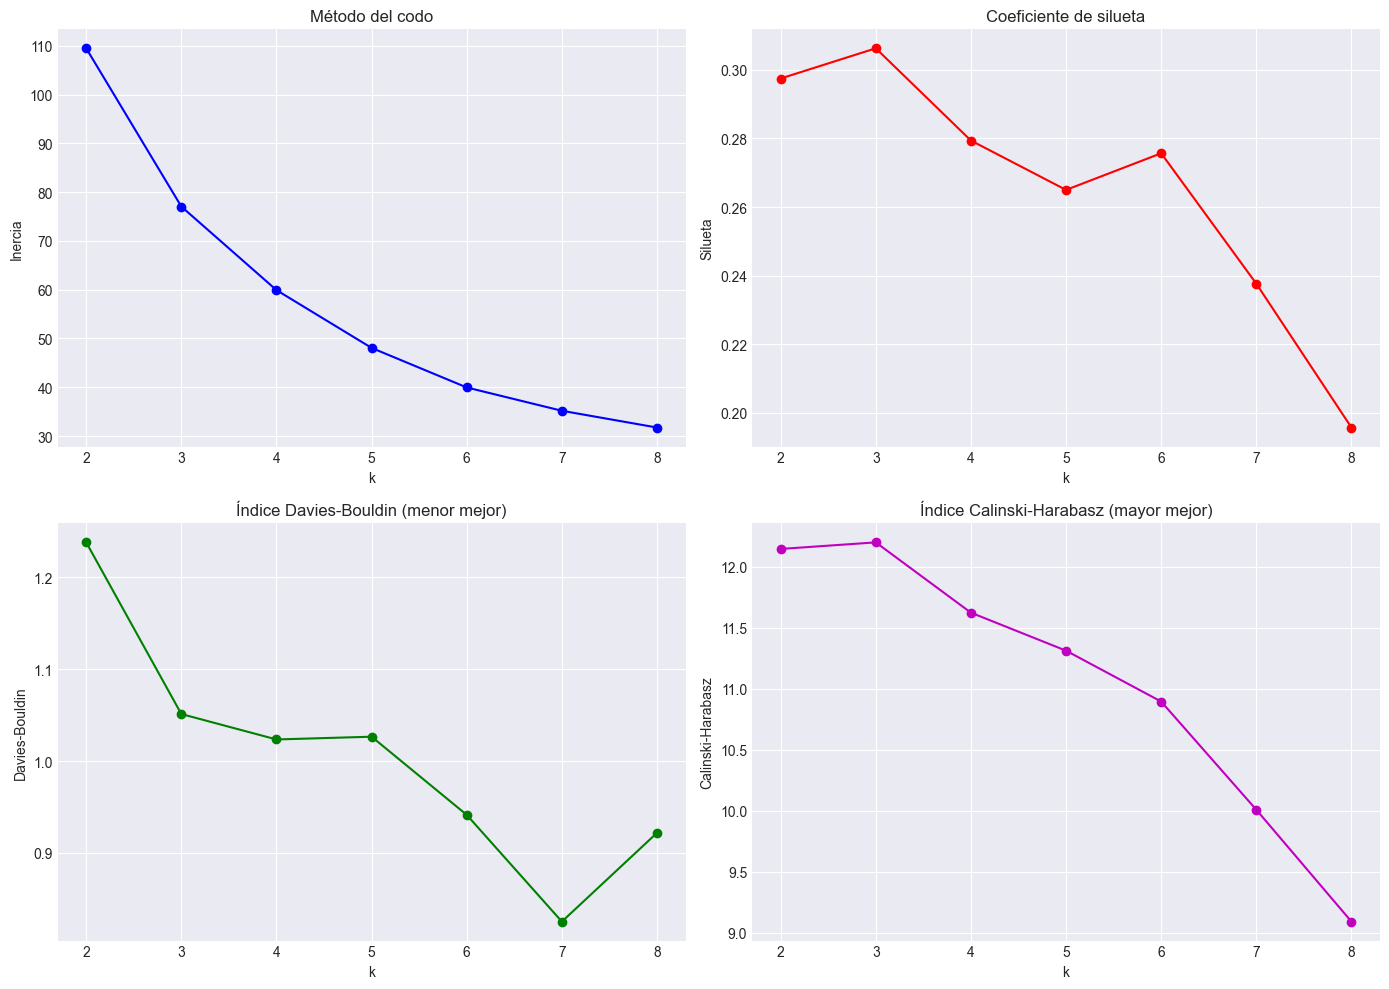

k=2: inercia=109.50, silueta=0.2975, DB=1.2380, CH=12.15
k=3: inercia=77.05, silueta=0.3063, DB=1.0511, CH=12.20
k=4: inercia=59.92, silueta=0.2794, DB=1.0235, CH=11.62
k=5: inercia=48.06, silueta=0.2650, DB=1.0265, CH=11.31
k=6: inercia=39.96, silueta=0.2757, DB=0.9414, CH=10.90
k=7: inercia=35.18, silueta=0.2376, DB=0.8252, CH=10.01
k=8: inercia=31.74, silueta=0.1957, DB=0.9218, CH=9.09

✅ k óptimo según silueta: 3
Métricas finales para k=3:
  Silueta: 0.3063
  Davies-Bouldin: 1.0511
  Calinski-Harabasz: 12.20
Perfil de clusters (medias de variables originales):
                  edad_hom_media_div  edad_muj_media_div  edad_hom_media_mat  \
cluster_duracion                                                               
0                              35.28               31.85               28.27   
1                              35.48               31.74               30.85   
2                              32.55               29.27               27.52   

                  edad_muj_m

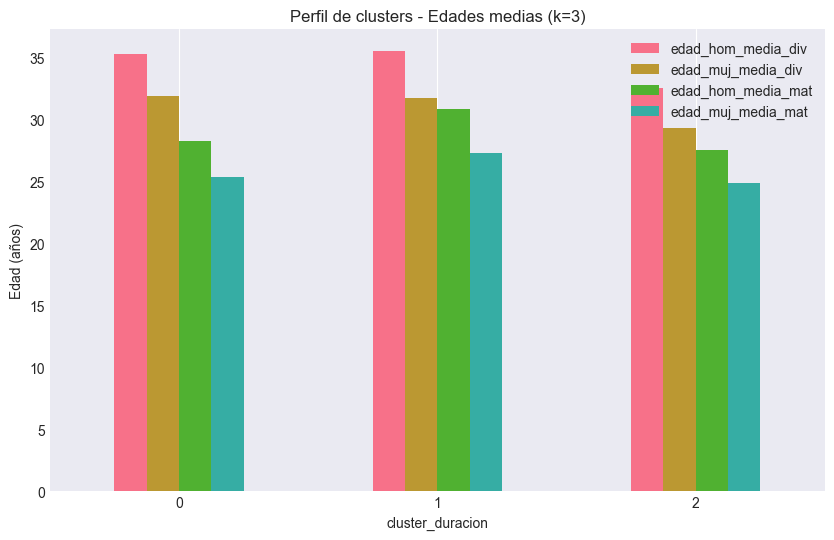

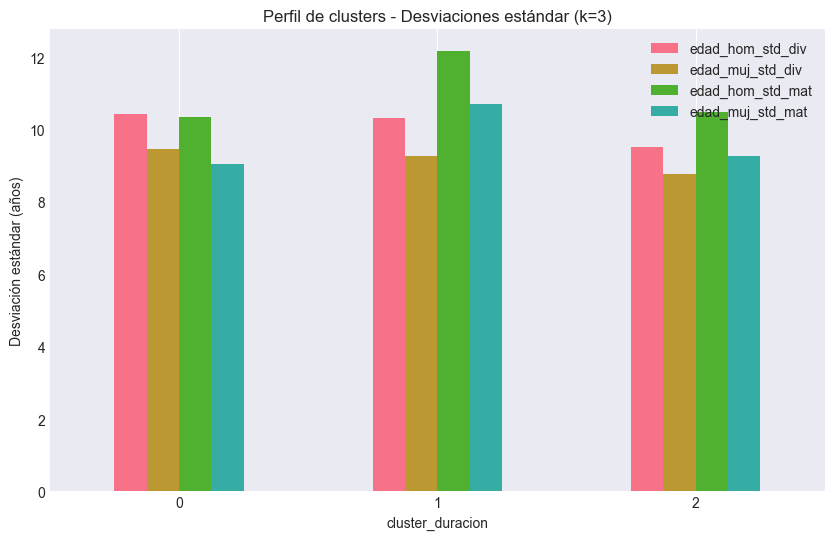

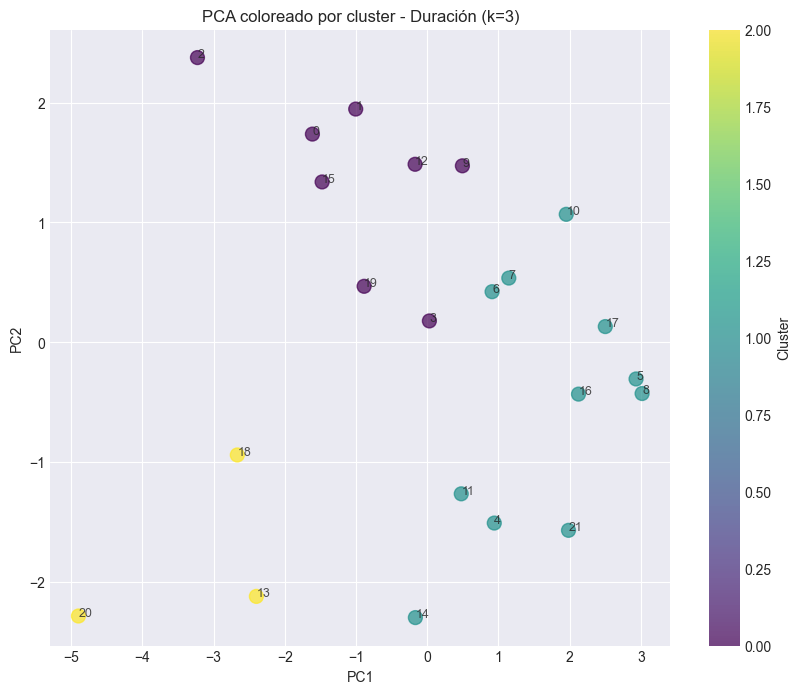

Adjusted Rand Index entre semillas 42 y 123: 1.0000
Distancia media entre centroides (alineados): 1.6315
RESUMEN DE CLUSTERS - DURACIÓN DEL MATRIMONIO
                  edad_hom_media_div  edad_muj_media_div  edad_hom_media_mat  \
cluster_duracion                                                               
0                              35.28               31.85               28.27   
1                              35.48               31.74               30.85   
2                              32.55               29.27               27.52   

                  edad_muj_media_mat  edad_hom_std_div  edad_muj_std_div  \
cluster_duracion                                                           
0                              25.34             10.43              9.46   
1                              27.32             10.33              9.27   
2                              24.88              9.53              8.76   

                  edad_hom_std_mat  edad_muj_std_mat  Tamaño  \
clu

In [8]:
# %% [markdown]
# # Bloque 3: Duración del Matrimonio - Clustering por departamento
# 
# Variables seleccionadas:
# - `edad_hom_media_div`, `edad_muj_media_div`: edades medias al divorcio.
# - `edad_hom_media_mat`, `edad_muj_media_mat`: edades medias al matrimonio.
# - `edad_hom_std_div`, `edad_muj_std_div`: desviación estándar de edades al divorcio.
# - `edad_hom_std_mat`, `edad_muj_std_mat`: desviación estándar de edades al matrimonio.
# 
# Objetivo: Identificar grupos de departamentos con patrones etarios similares (edades jóvenes vs adultas, homogeneidad vs heterogeneidad) que reflejen diferentes dinámicas familiares.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.utils import resample
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
from sklearn.metrics import adjusted_rand_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos si es necesario
# df_combinado = pd.read_csv('divorcios_matrimonios_combinado.csv', index_col=0)

# Verificar que tenemos las variables necesarias
vars_duracion = [
    'edad_hom_media_div',
    'edad_muj_media_div',
    'edad_hom_media_mat',
    'edad_muj_media_mat',
    'edad_hom_std_div',
    'edad_muj_std_div',
    'edad_hom_std_mat',
    'edad_muj_std_mat'
]

# Asegurar que no hay nulos
df_subset = df_combinado[vars_duracion].copy()
print("Valores nulos:")
print(df_subset.isnull().sum())

# Si hay nulos, imputar con la media (aunque ya lo hicimos antes)
if df_subset.isnull().sum().sum() > 0:
    df_subset = df_subset.fillna(df_subset.mean())

# %% [markdown]
# ## 1. Escalar variables
# Usaremos `StandardScaler` para que todas tengan media 0 y desviación 1.

# %%
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)
X_scaled = pd.DataFrame(X_scaled, columns=vars_duracion, index=df_subset.index)

print("Estadísticas después de escalar (medias deben ser ~0):")
print(X_scaled.mean())

# %% [markdown]
# ## 2. Visualización exploratoria (PCA y scatter matrix)

# %%
# Reducción a 2 dimensiones con PCA para visualizar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Varianza explicada por 2 componentes: {pca.explained_variance_ratio_.sum():.2%}")

# Scatter plot de las dos primeras componentes
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7, s=100)
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=9, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección PCA - Duración del Matrimonio')
plt.grid(True)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.show()

# Pairplot de las variables escaladas (podríamos seleccionar un subconjunto para no saturar)
# Elegimos solo las medias para simplificar
sns.pairplot(X_scaled[['edad_hom_media_div', 'edad_muj_media_div', 'edad_hom_media_mat', 'edad_muj_media_mat']], diag_kind='kde')
plt.suptitle('Pairplot de edades medias escaladas', y=1.02)
plt.show()

# %% [markdown]
# **Observación preliminar:** En el gráfico PCA podemos ver si hay agrupamientos naturales basados en perfiles etarios.

# %% [markdown]
# ## 3. Elección del algoritmo
# K-means es adecuado para buscar grupos basados en patrones de edad.

# %% [markdown]
# ## 4. Elegir el número óptimo de clusters (k)
# Probaremos k de 2 a 8.

# %%
K_range = range(2, 9)
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# %%
# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Codo
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del codo')
axes[0].grid(True)

# Silueta
axes[1].plot(K_range, sil_scores, 'ro-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silueta')
axes[1].set_title('Coeficiente de silueta')
axes[1].grid(True)

# Davies-Bouldin
axes[2].plot(K_range, db_scores, 'go-')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Davies-Bouldin')
axes[2].set_title('Índice Davies-Bouldin (menor mejor)')
axes[2].grid(True)

# Calinski-Harabasz
axes[3].plot(K_range, ch_scores, 'mo-')
axes[3].set_xlabel('k')
axes[3].set_ylabel('Calinski-Harabasz')
axes[3].set_title('Índice Calinski-Harabasz (mayor mejor)')
axes[3].grid(True)

plt.tight_layout()
plt.show()

# %%
# Mostrar valores numéricos
for k, inert, sil, db, ch in zip(K_range, inertias, sil_scores, db_scores, ch_scores):
    print(f"k={k}: inercia={inert:.2f}, silueta={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")

# Elegir k según el criterio (maximizar silueta)
k_optimo = K_range[np.argmax(sil_scores)]
print(f"\n✅ k óptimo según silueta: {k_optimo}")

# %% [markdown]
# ## 5. Evaluar métricas con el k elegido
# Aplicamos K-means con k_optimo.

# %%
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_final = kmeans_final.fit_predict(X_scaled)
df_combinado['cluster_duracion'] = labels_final

# Métricas finales
sil_final = silhouette_score(X_scaled, labels_final)
db_final = davies_bouldin_score(X_scaled, labels_final)
ch_final = calinski_harabasz_score(X_scaled, labels_final)

print(f"Métricas finales para k={k_optimo}:")
print(f"  Silueta: {sil_final:.4f}")
print(f"  Davies-Bouldin: {db_final:.4f}")
print(f"  Calinski-Harabasz: {ch_final:.2f}")

# %% [markdown]
# ## 6. Interpretar los clusters
# Calculamos las medias de las variables originales (sin escalar) por cluster.

# %%
# Perfil de clusters con variables originales
perfil = df_combinado.groupby('cluster_duracion')[vars_duracion].mean().round(2)
print("Perfil de clusters (medias de variables originales):")
print(perfil)

# Tamaño de cada cluster
tamanio = df_combinado['cluster_duracion'].value_counts().sort_index()
print("\nTamaño de cada cluster:")
print(tamanio)

# Lista de departamentos por cluster
for c in range(k_optimo):
    deptos = df_combinado[df_combinado['cluster_duracion'] == c].index.tolist()
    print(f"\nCluster {c}: {deptos}")

# %%
# Visualización de perfiles (barras) - Solo las medias de edad
perfil_edades = perfil[['edad_hom_media_div', 'edad_muj_media_div', 'edad_hom_media_mat', 'edad_muj_media_mat']]
perfil_edades.plot(kind='bar', figsize=(10,6))
plt.title(f'Perfil de clusters - Edades medias (k={k_optimo})')
plt.ylabel('Edad (años)')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

# Desviaciones estándar
perfil_std = perfil[['edad_hom_std_div', 'edad_muj_std_div', 'edad_hom_std_mat', 'edad_muj_std_mat']]
perfil_std.plot(kind='bar', figsize=(10,6))
plt.title(f'Perfil de clusters - Desviaciones estándar (k={k_optimo})')
plt.ylabel('Desviación estándar (años)')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.show()

# PCA coloreado por cluster
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_final, cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Cluster')
for i, depto in enumerate(X_scaled.index):
    plt.annotate(depto, (X_pca[i, 0], X_pca[i, 1]), fontsize=9, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA coloreado por cluster - Duración (k={k_optimo})')
plt.grid(True)
plt.show()

# %% [markdown]
# **Interpretación de los clusters:**
# - Cluster con edades al matrimonio jóvenes y edades al divorcio también jóvenes → ciclo rápido.
# - Cluster con edades al matrimonio adultas y divorcio adulto → ciclo más tardío.
# - Desviaciones altas indican mayor heterogeneidad interna en el departamento.

# %% [markdown]
# ## 7. Validar estabilidad del clustering

# %%
# Cambio de semilla
kmeans_semilla2 = KMeans(n_clusters=k_optimo, random_state=123, n_init=10)
labels_semilla2 = kmeans_semilla2.fit_predict(X_scaled)

rand = adjusted_rand_score(labels_final, labels_semilla2)
print(f"Adjusted Rand Index entre semillas 42 y 123: {rand:.4f}")

# Bootstrap
np.random.seed(42)
indices = np.random.choice(len(X_scaled), size=int(0.8*len(X_scaled)), replace=True)
X_bootstrap = X_scaled.iloc[indices]
kmeans_boot = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_boot = kmeans_boot.fit_predict(X_bootstrap)

# Comparar centroides
centroides_original = kmeans_final.cluster_centers_
centroides_boot = kmeans_boot.cluster_centers_

cost_matrix = distance.cdist(centroides_original, centroides_boot)
row_ind, col_ind = linear_sum_assignment(cost_matrix)
distancia_media = cost_matrix[row_ind, col_ind].mean()
print(f"Distancia media entre centroides (alineados): {distancia_media:.4f}")

# %% [markdown]
# ## 8. Comunicar resultados

# %%
# Crear tabla resumen
resumen = perfil.copy()
resumen['Tamaño'] = tamanio
resumen['Departamentos'] = [df_combinado[df_combinado['cluster_duracion'] == c].index.tolist() for c in range(k_optimo)]

print("="*60)
print("RESUMEN DE CLUSTERS - DURACIÓN DEL MATRIMONIO")
print("="*60)
print(resumen)

# Insight final (personalizar según valores obtenidos)
print(f"""
🔍 **Conclusión sobre Duración del Matrimonio:**
- Se identificaron {k_optimo} patrones etarios distintos entre los departamentos.
- Cluster 0: {resumen.loc[0, 'Departamentos']} → { 'Edades jóvenes y poca dispersión' if resumen.loc[0, 'edad_hom_media_mat'] < 25 else 'Edades adultas' }.
- Cluster 1: ... (completar según resultados).
- Estos perfiles reflejan diferencias culturales o socioeconómicas en los ciclos familiares.
""")